In [1]:
#query the data from Spanner
import os
from google.cloud import spanner
import random
import string
from google.oauth2 import service_account
import base64
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

class StreamDeFiFutures():

    def __init__(self):
        pass

    @staticmethod
    def query():
        instance_id = "defi"
        database_id = "futuresfunding"
        creds = service_account.Credentials.from_service_account_file("key.json")
        spanner_client = spanner.Client(credentials=creds)
        instance = spanner_client.instance(instance_id)
        db = instance.database(database_id)
        with db.snapshot(multi_use=True) as snapshot:
            results = snapshot.execute_sql("SELECT * FROM StreamDeFiFutures ORDER BY OBSERVATION_TIME ASC")
            rows = list(results)
            fields = results.fields
            return_arr = []
            row_counter = 0
            for row in rows:  # for each result
                temp_dict = {}
                field_counter = 0
                for datarow in row:  # for each field
                    temp_dict[fields[field_counter].name] = \
                    rows[row_counter][field_counter]  # construct a dict
                    field_counter = field_counter + 1
                return_arr.append(temp_dict)
                row_counter = row_counter + 1

            aa = return_arr
            return return_arr
        
strm = StreamDeFiFutures()
aa = strm.query()
df_temp = pd.DataFrame(data=aa)

In [2]:

%%time
bigdata = df_temp
bigdata.sort_values(by=['OBSERVATION_TIME'],ascending=True, inplace=True)
datafra=bigdata.reset_index(drop=True)


shift = -10

datafra['hour'] = datafra['OBSERVATION_TIME'].dt.hour
datafra['minute'] = datafra['OBSERVATION_TIME'].dt.minute
datafra['seasonality_1m'] = datafra['OBSERVATION_TIME'].astype(np.int64)/10000000000 % (60)

datafra['price_delta100'] = datafra['MID_PRICE'].pct_change(periods=100)

datafra['_target_time'] = datafra['OBSERVATION_TIME'].shift(shift)
datafra['_target_price'] = datafra['MID_PRICE'].shift(shift)
datafra['target_delta'] = datafra['_target_price']-datafra['MID_PRICE']

datafra['_time_delta'] = datafra['_target_time']-datafra['OBSERVATION_TIME']

print('avg lookahead ' +str(np.sum(datafra['_time_delta'])/len(datafra)))

horizon = np.sum(datafra['_time_delta'])/len(datafra)


#3) cleanse data 
datafra = datafra.dropna()

datafra = datafra.drop(['DATA_KEY','OBSERVATION_TIME','MID_PRICE','SYMBOL','_time_delta','_target_time', '_target_price','SHORT_FUNDING'], axis=1)


#convert object type to float and remove categorical

for col in datafra.columns:
    #if col.endswith("_STR"):
    #print(col + " " + str(datafra[col].dtype))
    datafra[col] = datafra[col].astype(np.float64)
    pass

#datafra
datafra.info()


#4) split data into training and test 



from sklearn.model_selection import train_test_split
X, y = datafra.iloc[:,:-1],datafra.iloc[:,-1] # 2 - remove actual number and first seasonality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123,shuffle=False)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_test, label=y_test)


evallist = [(dvalidation, 'validation'), (dtrain, 'train')]


print("X Train length " + str(len(X_train)))
print("y Train length " + str(len(y_train)))
 
print("Test length X_test " + str(len(X_test)))
print("Validaton length y_test " + str(len(y_test)))
datafra

avg lookahead 0 days 00:01:10.394390771
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8476 entries, 100 to 8575
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FUNDING         8476 non-null   float64
 1   OPEN_INTEREST   8476 non-null   float64
 2   ORACLE_PRICE    8476 non-null   float64
 3   LONG_FUNDING    8476 non-null   float64
 4   APR             8476 non-null   float64
 5   APY             8476 non-null   float64
 6   SPREAD          8476 non-null   float64
 7   hour            8476 non-null   float64
 8   minute          8476 non-null   float64
 9   seasonality_1m  8476 non-null   float64
 10  price_delta100  8476 non-null   float64
 11  target_delta    8476 non-null   float64
dtypes: float64(12)
memory usage: 860.8 KB
X Train length 6780
y Train length 6780
Test length X_test 1696
Validaton length y_test 1696
CPU times: user 69.5 ms, sys: 16 ms, total: 85.5 ms
Wall time: 83.2 ms


,FUNDING,OPEN_INTEREST,ORACLE_PRICE,LONG_FUNDING,APR,APY,SPREAD,hour,minute,seasonality_1m,price_delta100,target_delta
100,-0.000014,374245.31,40.641130,148554.672245,-0.124339,-0.116921,0.01,17.0,29.0,59.516167,-0.001718,0.000
101,-0.000014,374245.31,40.641130,148554.672245,-0.124339,-0.116921,0.01,17.0,30.0,0.163771,-0.001841,0.010
102,-0.000014,374245.31,40.641130,148554.672245,-0.124339,-0.116921,0.01,17.0,30.0,0.808492,-0.001841,0.010
103,-0.000014,374245.31,40.639375,148554.672245,-0.123006,-0.115743,0.02,17.0,30.0,1.467731,-0.001718,0.005
104,-0.000014,374245.31,40.639375,148554.672245,-0.123006,-0.115743,0.02,17.0,30.0,2.118895,-0.001596,-0.005
...,...,...,...,...,...,...,...,...,...,...,...,...
8571,-0.000010,365224.82,42.630400,148554.672245,-0.084673,-0.081187,0.03,10.0,5.0,32.279302,-0.000821,0.000
8572,-0.000010,365224.82,42.630400,148554.672245,-0.084673,-0.081187,0.03,10.0,5.0,32.967589,-0.000938,0.000
8573,-0.000010,365224.82,42.639400,148554.672245,-0.085457,-0.081908,0.03,10.0,5.0,33.701662,-0.000703,0.000
8574,-0.000010,365224.82,42.639400,148554.672245,-0.085457,-0.081908,0.02,10.0,5.0,34.374648,-0.000586,-0.005


In [3]:
#adjust the hyperparams // enable disable GPU support 
params = {"objective":"reg:squarederror",
          'colsample_bytree': 1,
          'learning_rate': 0.05,
          'normalize_type' : 'tree',
          'max_depth': 20 , 
          'alpha': 0.99,
           #remove/add if there is not GPU support  'tree_method':'gpu_hist',
          'early_stopping_rounds':5,
          'lambda':0.1,
          'num_parallel_tree':1,
          'gamma':0.1,
          'booster': 'dart',
          'feature_selector':'random',
          'subsample':1,
         'rate_drop':0.1,
         'top_k':3,
         'eval_metric':'mae'}
num_round = 50


bst = xgb.train(params, dtrain, num_round, evallist)

[14:00:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "feature_selector", "top_k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation-mae:0.47500	train-mae:0.47231
[1]	validation-mae:0.45139	train-mae:0.44870
[2]	validation-mae:0.42896	train-mae:0.42628
[3]	validation-mae:0.40766	train-mae:0.40497
[4]	validation-mae:0.38742	train-mae:0.38474
[5]	validation-mae:0.38111	train-mae:0.37843
[6]	validation-mae:0.36220	train-mae:0.35955
[7]	validation-mae:0.34423	train-mae:0.34162
[8]	validation-mae:0.32716	train-mae:0.32459
[9]	validation-mae:0.31172	train-mae:0.30918
[10]	validation-mae:0.29701	train-mae:0.29451
[11]	validation

/Users/gman7/trebuchet/mango-explorer/venv/lib/python3.9/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[26]	validation-mae:0.17891	train-mae:0.17681
[27]	validation-mae:0.17057	train-mae:0.16851
[28]	validation-mae:0.16891	train-mae:0.16687
[29]	validation-mae:0.16489	train-mae:0.16286
[30]	validation-mae:0.15721	train-mae:0.15525
[31]	validation-mae:0.14990	train-mae:0.14802
[32]	validation-mae:0.14751	train-mae:0.14565
[33]	validation-mae:0.14574	train-mae:0.14389
[34]	validation-mae:0.14228	train-mae:0.14047
[35]	validation-mae:0.13892	train-mae:0.13714
[36]	validation-mae:0.13796	train-mae:0.13619
[37]	validation-mae:0.13686	train-mae:0.13510
[38]	validation-mae:0.13522	train-mae:0.13348
[39]	validation-mae:0.12899	train-mae:0.12732
[40]	validation-mae:0.12830	train-mae:0.12664
[41]	validation-mae:0.12241	train-mae:0.12082
[42]	validation-mae:0.12096	train-mae:0.11939
[43]	validation-mae:0.11952	train-mae:0.11797
[44]	validation-mae:0.11839	train-mae:0.11685
[45]	validation-mae:0.11698	train-mae:0.11547
[46]	validation-mae:0.11587	train-mae:0.11437
[47]	validation-mae:0.11450	train-

<AxesSubplot:>

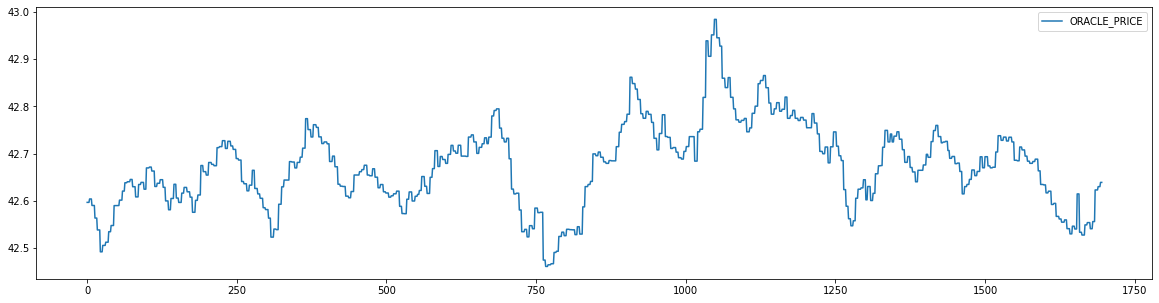

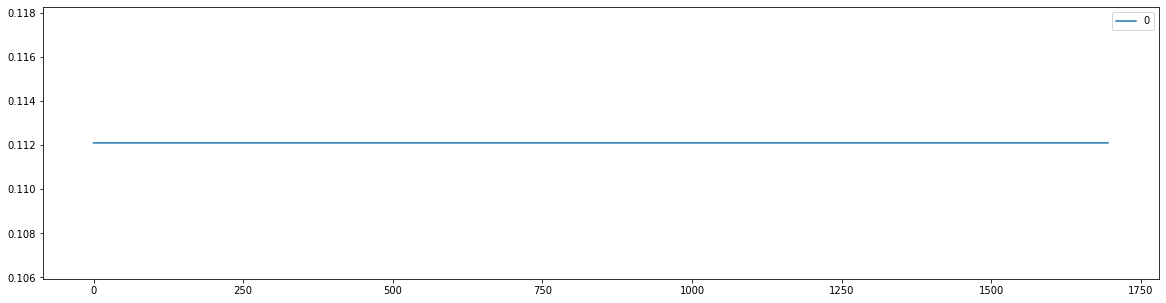

In [5]:
#plot the prediction delta with original price
from xgboost import plot_tree

aaa = bst.predict(dvalidation)

df2 = pd.DataFrame(aaa)
df3 = pd.DataFrame(X_test['ORACLE_PRICE'])
df3.reset_index(inplace=True)

res = pd.concat([df2, df3], axis=1)
res.drop(['index'], axis=1,inplace=True)
df3.drop(['index'], axis=1,inplace=True)

df3.plot(figsize=(20,5))
df2.plot(figsize=(20,5))

In [24]:
# get feature importance 
bst.get_score(importance_type='weight')

{'FUNDING': 102.0,
 'OPEN_INTEREST': 202.0,
 'ORACLE_PRICE': 317.0,
 'APR': 29.0,
 'hour': 37.0,
 'minute': 200.0,
 'seasonality_1m': 12.0,
 'seasonality_1h': 262.0,
 'price_delta100': 128.0}

<AxesSubplot:>

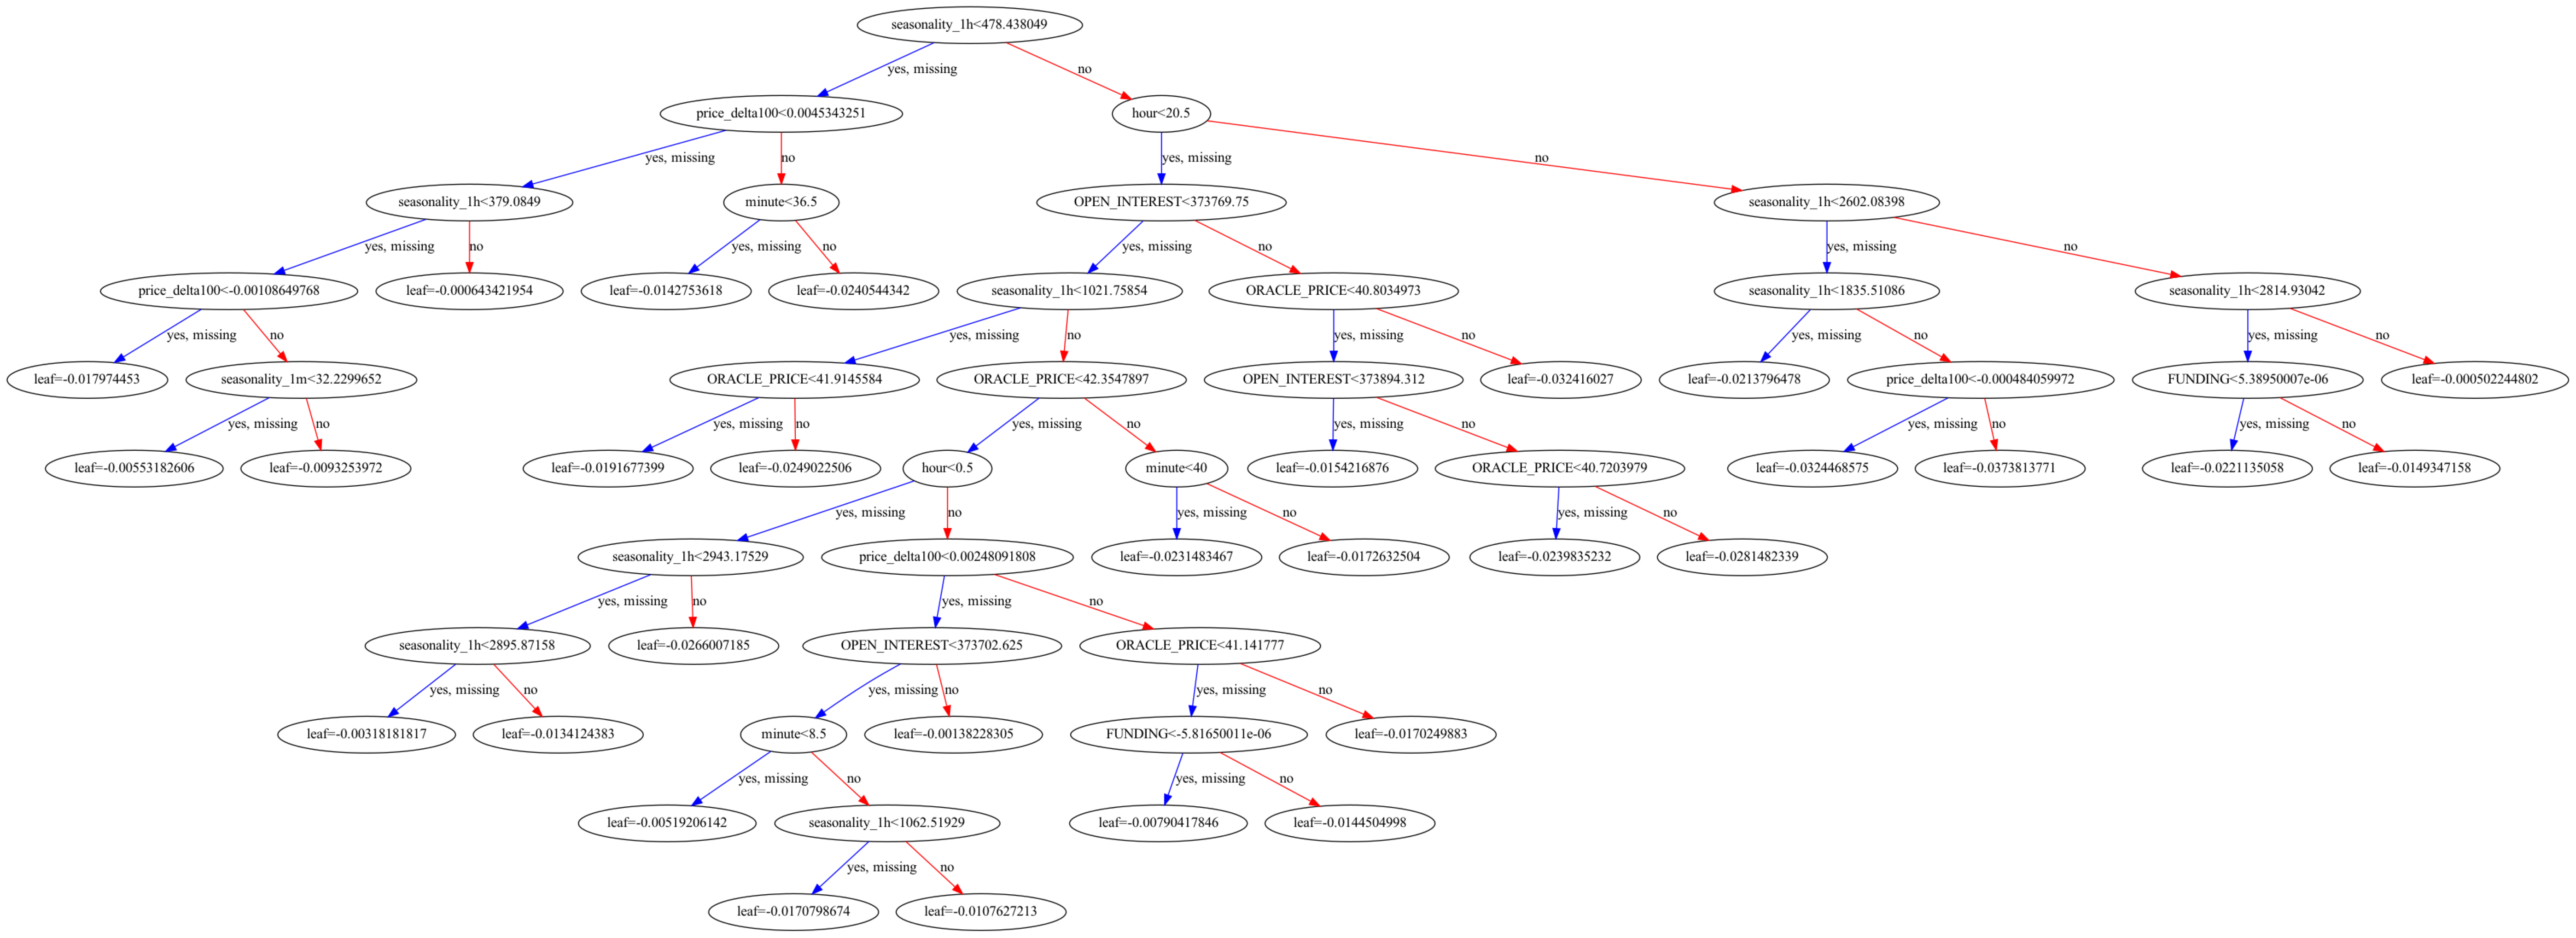

In [26]:
# display the model 

from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 100,75

plot_tree(bst)